# Survival Analysis

## Imports

In [2]:
import numpy as np 
import pandas as pd 
import scanpy as sc 
import matplotlib.pyplot as plt
import warnings
plt.rcParams['figure.facecolor'] = 'white'
warnings.filterwarnings("ignore")

sc.settings.verbosity = 3 

sc.settings.set_figure_params(dpi = 80)

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline, make_pipeline

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
import seaborn as sns
from sklearn.linear_model import LassoCV
import xgboost as xgb
from sksurv.linear_model import CoxPHSurvivalAnalysis, CoxnetSurvivalAnalysis
from sksurv.metrics import concordance_index_censored





## Gene Data

In [3]:
# read the gene expression data: 
raw_data_rna = pd.read_table("./data/data_mrna_seq_v2_rsem.txt", sep="\t")
raw_data_rna.head()

,Hugo_Symbol,Entrez_Gene_Id,TCGA-CS-4938-01,TCGA-CS-4941-01,TCGA-CS-4942-01,TCGA-CS-4943-01,TCGA-CS-4944-01,TCGA-CS-5390-01,TCGA-CS-5393-01,TCGA-CS-5394-01,...,TCGA-VW-A8FI-01,TCGA-W9-A837-01,TCGA-WH-A86K-01,TCGA-WY-A858-01,TCGA-WY-A859-01,TCGA-WY-A85A-01,TCGA-WY-A85B-01,TCGA-WY-A85C-01,TCGA-WY-A85D-01,TCGA-WY-A85E-01
0,NaN,100130426,0.0000,0.0000,0.0000,0.0000,0.000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
1,NaN,100133144,8.7141,36.4493,11.8131,8.6116,0.000,5.3382,3.7845,8.3071,...,19.1299,12.5770,10.9796,7.8225,3.3371,5.4526,8.2616,11.5121,5.3895,9.9433
2,UBE2Q2P2,100134869,22.7523,21.1767,11.0242,5.0835,30.261,27.8886,8.7230,15.4466,...,21.9905,27.0125,14.2608,16.6975,10.2310,16.1890,19.7074,18.7291,8.9103,7.4480
3,HMGB1P1,10357,268.5760,156.6870,185.1380,269.8360,216.341,159.7590,198.1880,208.5410,...,127.7470,106.8290,205.5170,184.4080,125.5470,124.9190,133.7390,120.9240,107.2540,143.0060
4,NaN,10431,845.8150,390.2690,621.4530,835.7290,812.508,576.9050,551.9470,607.8960,...,564.3620,603.3720,570.9130,760.7160,875.1410,658.2210,662.6510,524.7240,705.1280,748.5820


In [4]:
# choosing Entrez_Gene_Id as column because: 
print(f"There are {len(raw_data_rna[raw_data_rna.Entrez_Gene_Id.isna()])} genes has no ids")
print("we would use Entrez_Gene_Id as name of gene with a correponding dictionary table")
gene_symbol_id = raw_data_rna.iloc[:,:2].copy()
gene_symbol_id.tail()

There are 0 genes has no ids
we would use Entrez_Gene_Id as name of gene with a correponding dictionary table


,Hugo_Symbol,Entrez_Gene_Id
20526,ZYG11A,440590
20527,ZYG11B,79699
20528,ZYX,7791
20529,ZZEF1,23140
20530,ZZZ3,26009


In [5]:
# transpose the data and make the gene id as the column names: 
df_clean = raw_data_rna.set_index("Entrez_Gene_Id").drop("Hugo_Symbol", axis = 1).transpose()
print(f"There are {len(df_clean)} samples in total, and there are {len(df_clean.columns)} genes in total.")
df_clean.head()

There are 514 samples in total, and there are 20531 genes in total.


Entrez_Gene_Id,100130426,100133144,100134869,10357,10431,136542,155060,26823,280660,317712,...,55055,11130,7789,158586,79364,440590,79699,7791,23140,26009
TCGA-CS-4938-01,0.0,8.7141,22.7523,268.576,845.815,0.0,182.505,0.4196,0.0,0.0,...,80.1636,50.3461,64.1913,523.180,1311.52,0.0000,1495.70,1598.91,1171.810,836.165
TCGA-CS-4941-01,0.0,36.4493,21.1767,156.687,390.269,0.0,325.052,1.7253,0.0,0.0,...,187.2980,110.4210,105.9350,467.564,1226.71,0.3451,1751.21,3889.92,1707.730,1015.530
TCGA-CS-4942-01,0.0,11.8131,11.0242,185.138,621.453,0.0,131.142,0.0000,0.0,0.0,...,120.0310,186.5050,115.2250,454.325,1102.42,0.3460,1586.16,2214.53,1423.880,706.920
TCGA-CS-4943-01,0.0,8.6116,5.0835,269.836,835.729,0.0,83.475,0.3261,0.0,0.0,...,667.4480,1183.6500,89.0183,491.068,1288.32,3.2607,1760.15,2131.55,1916.990,689.321
TCGA-CS-4944-01,0.0,0.0000,30.2610,216.341,812.508,0.0,80.696,0.0000,0.0,0.0,...,57.3244,56.4872,42.3654,323.793,1012.73,0.5044,1225.07,1692.60,729.794,456.941


In [6]:
# check the quality of the data: 
# 1) if there is any NA data
print(f"If there is NA values: {df_clean.isnull().values.any()}")

# 2) if there are columns with all the same value
unique_counts = df_clean.nunique()
same_value_cols = unique_counts[unique_counts == 1].index.tolist()
print(f"There are {len(same_value_cols)} columns with the same value.")
print(f"{same_value_cols[0:10]}...")

If there is NA values: False
There are 307 columns with the same value.
[136542, 317712, 728045, 728036, 255313, 728096, 728062, 653282, 728042, 57135]...


In [7]:
# thus, we need to drop all of same_value_cols: 
df_clean_1 = df_clean.drop(same_value_cols, axis = 1)
df_clean_1.head(3)

Entrez_Gene_Id,100130426,100133144,100134869,10357,10431,155060,26823,280660,340602,388795,...,55055,11130,7789,158586,79364,440590,79699,7791,23140,26009
TCGA-CS-4938-01,0.0,8.7141,22.7523,268.576,845.815,182.505,0.4196,0.0,2.0978,0.4196,...,80.1636,50.3461,64.1913,523.180,1311.52,0.0000,1495.70,1598.91,1171.81,836.165
TCGA-CS-4941-01,0.0,36.4493,21.1767,156.687,390.269,325.052,1.7253,0.0,3.4507,0.3451,...,187.2980,110.4210,105.9350,467.564,1226.71,0.3451,1751.21,3889.92,1707.73,1015.530
TCGA-CS-4942-01,0.0,11.8131,11.0242,185.138,621.453,131.142,0.0000,0.0,1.7301,0.3460,...,120.0310,186.5050,115.2250,454.325,1102.42,0.3460,1586.16,2214.53,1423.88,706.920


In [8]:
df_clean_1

Entrez_Gene_Id,100130426,100133144,100134869,10357,10431,155060,26823,280660,340602,388795,...,55055,11130,7789,158586,79364,440590,79699,7791,23140,26009
TCGA-CS-4938-01,0.0,8.7141,22.7523,268.576,845.815,182.505,0.4196,0.0,2.0978,0.4196,...,80.1636,50.3461,64.1913,523.180,1311.520,0.0000,1495.70,1598.91,1171.810,836.165
TCGA-CS-4941-01,0.0,36.4493,21.1767,156.687,390.269,325.052,1.7253,0.0,3.4507,0.3451,...,187.2980,110.4210,105.9350,467.564,1226.710,0.3451,1751.21,3889.92,1707.730,1015.530
TCGA-CS-4942-01,0.0,11.8131,11.0242,185.138,621.453,131.142,0.0000,0.0,1.7301,0.3460,...,120.0310,186.5050,115.2250,454.325,1102.420,0.3460,1586.16,2214.53,1423.880,706.920
TCGA-CS-4943-01,0.0,8.6116,5.0835,269.836,835.729,83.475,0.3261,0.0,1.3043,0.0000,...,667.4480,1183.6500,89.0183,491.068,1288.320,3.2607,1760.15,2131.55,1916.990,689.321
TCGA-CS-4944-01,0.0,0.0000,30.2610,216.341,812.508,80.696,0.0000,0.0,3.0261,0.0000,...,57.3244,56.4872,42.3654,323.793,1012.730,0.5044,1225.07,1692.60,729.794,456.941
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-WY-A85A-01,0.0,5.4526,16.1890,124.919,658.221,540.512,1.0557,0.0,7.3898,2.1114,...,101.8580,97.1233,53.8401,351.016,1263.130,0.0000,1491.69,1497.49,1556.080,664.555
TCGA-WY-A85B-01,0.0,8.2616,19.7074,133.739,662.651,610.155,2.1515,0.0,11.1876,0.0000,...,241.3380,349.3980,60.2410,503.012,1347.680,0.8606,1443.63,1574.87,1685.890,836.919
TCGA-WY-A85C-01,0.0,11.5121,18.7291,120.924,524.724,837.760,3.2693,0.0,13.4859,0.4087,...,96.6817,78.0548,76.4201,530.854,1556.190,2.8606,1855.74,1927.67,2006.130,910.094
TCGA-WY-A85D-01,0.0,5.3895,8.9103,107.254,705.128,805.720,0.4931,0.0,7.3964,0.4931,...,49.8570,111.9330,35.0099,312.130,1456.110,0.0000,1222.88,1706.11,1429.490,771.203


In [9]:
adata= sc.AnnData(df_clean_1)

normalizing counts per cell
    finished (0:00:00)


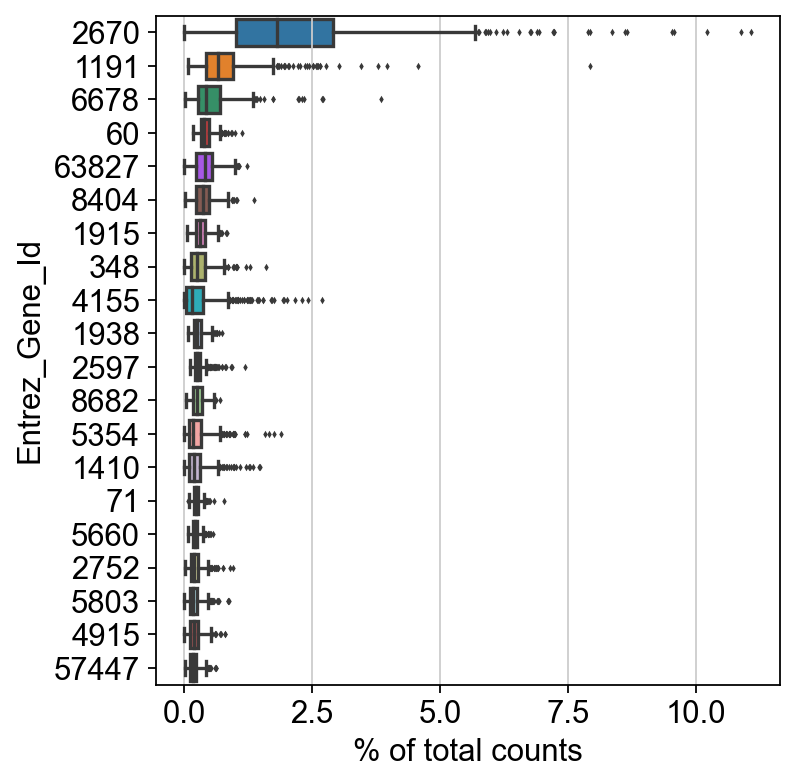

In [10]:
sc.pl.highest_expr_genes(adata, n_top=20, )
#Show those genes that yield the highest fraction of counts in each single cell, across all cells.

## Clustering

computing PCA
    with n_comps=50
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:15)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:01)
running Leiden clustering
    finished: found 9 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


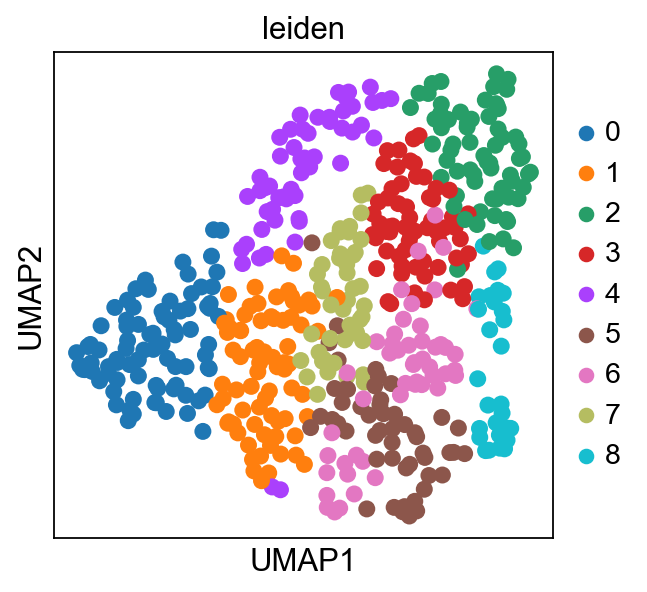

In [11]:
sc.tl.pca(adata, n_comps=50)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.tl.leiden(adata)
sc.pl.umap(adata, color='leiden')

In [12]:
pd.DataFrame(adata.obs['leiden'])

,leiden
TCGA-CS-4938-01,0
TCGA-CS-4941-01,4
TCGA-CS-4942-01,1
TCGA-CS-4943-01,3
TCGA-CS-4944-01,0
...,...
TCGA-WY-A85A-01,3
TCGA-WY-A85B-01,7
TCGA-WY-A85C-01,7
TCGA-WY-A85D-01,0


In [13]:
print("Explained variance of PCA:" , adata.uns['pca']['variance_ratio'].sum())

Explained variance of PCA: 0.9786677


In [14]:
clusters_df = pd.DataFrame(adata.obs['leiden']).reset_index(level=0)
clusters_df['index'] = clusters_df['index'].str[:-3]

In [15]:
df_PC = pd.DataFrame(adata.obsm['X_pca'])
df_PC['index'] = clusters_df['index']
df_PC  = df_PC.add_prefix('PC_')
df_PC.head()

,PC_0,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,PC_8,PC_9,...,PC_41,PC_42,PC_43,PC_44,PC_45,PC_46,PC_47,PC_48,PC_49,PC_index
0,1.179481e+06,-3.552642e+05,142728.703125,-66089.609375,-9366.514648,-134085.140625,32142.654297,1342.616943,57710.222656,-30445.576172,...,-5897.311523,-5377.030273,1698.723755,-8273.833984,-2018.937256,-3885.513184,-1345.705933,-7602.944336,7588.778320,TCGA-CS-4938
1,1.552628e+05,1.553124e+04,12386.751953,-60373.253906,-108076.195312,-71451.773438,-60999.855469,-14934.887695,80201.281250,-43944.554688,...,52223.601562,32406.591797,24187.460938,98311.546875,96527.328125,-40214.164062,-19525.748047,-38186.339844,81408.773438,TCGA-CS-4941
2,2.469720e+05,-1.232406e+05,47266.164062,-49504.031250,-41071.097656,-24860.027344,5952.747070,3249.116211,33062.273438,13538.092773,...,-11377.641602,-4925.553711,2720.064941,-4746.363770,1902.203491,17526.826172,9021.304688,-6246.499023,-5797.135254,TCGA-CS-4942
3,-2.733609e+05,-5.696276e+04,19343.726562,-60403.152344,-36205.476562,35807.664062,6154.285156,-30828.287109,-14537.517578,-4112.040039,...,136.382721,8045.645996,9371.277344,3556.511963,-7154.979492,12373.840820,-1976.640259,5021.790039,14219.029297,TCGA-CS-4943
4,2.480936e+06,1.119643e+06,-357928.187500,-119673.171875,40168.746094,163501.718750,457091.250000,-199761.359375,-106582.921875,236627.890625,...,11714.333008,5041.753906,18536.693359,11688.905273,16830.919922,-20021.898438,2092.509277,-3554.354004,-23399.783203,TCGA-CS-4944


## Clinical Patient Data

In [16]:
data_patient = pd.read_table('data/data_clinical_patient.txt', sep='\t')
print(data_patient.iloc[0])


#Patient Identifier                                                                                   #Identifier to uniquely specify a patient.
Subtype                                                                                                                                  Subtype
TCGA PanCanAtlas Cancer Type Acronym                                                           Text field to hold cancer type acronym used by...
Other Patient ID                                                                                         Legacy DMP patient identifier (DMPnnnn)
Diagnosis Age                                                                                  Age at which a condition or disease was first ...
Sex                                                                                                                                          Sex
Neoplasm Disease Stage American Joint Committee on Cancer Code                                 The extent of a cancer, especially 

In [17]:
data_patient = data_patient.drop([0,1,2,3], axis = 0)
df_patient = data_patient.reset_index(drop=True)

In [18]:
df_patient.head()

,#Patient Identifier,Subtype,TCGA PanCanAtlas Cancer Type Acronym,Other Patient ID,Diagnosis Age,Sex,Neoplasm Disease Stage American Joint Committee on Cancer Code,American Joint Committee on Cancer Publication Version Type,Last Communication Contact from Initial Pathologic Diagnosis Date,Birth from Initial Pathologic Diagnosis Date,...,Patient Weight,In PanCan Pathway Analysis,Overall Survival Status,Overall Survival (Months),Disease-specific Survival status,Months of disease-specific survival,Disease Free Status,Disease Free (Months),Progression Free Status,Progress Free Survival (Months)
0,TCGA-CS-4938,LGG_IDHmut-non-codel,LGG,334f715e-08dc-4a29-b8e4-b010b829c478,31,Female,NaN,NaN,3574,-11509,...,NaN,Yes,0:LIVING,117.5000822,0:ALIVE OR DEAD TUMOR FREE,117.5000822,NaN,NaN,0:CENSORED,117.5000822
1,TCGA-CS-4941,LGG_IDHwt,LGG,fc222f23-b3b2-4ac0-bc61-e8e8fa5cc160,67,Male,NaN,NaN,NaN,-24578,...,NaN,Yes,1:DECEASED,7.693066377,1:DEAD WITH TUMOR,7.693066377,NaN,NaN,1:PROGRESSION,0.295887168
2,TCGA-CS-4942,LGG_IDHmut-non-codel,LGG,230f5fa7-aa36-41ea-b40b-08f520767bd5,44,Female,NaN,NaN,NaN,-16297,...,NaN,Yes,1:DECEASED,43.88992997,1:DEAD WITH TUMOR,43.88992997,NaN,NaN,1:PROGRESSION,38.92560082
3,TCGA-CS-4943,LGG_IDHmut-non-codel,LGG,952dfd5d-e65a-4307-b6a9-2ed2b0d2d9ce,37,Male,NaN,NaN,552,-13565,...,NaN,Yes,1:DECEASED,36.36124536,1:DEAD WITH TUMOR,36.36124536,NaN,NaN,1:PROGRESSION,36.36124536
4,TCGA-CS-4944,LGG_IDHmut-non-codel,LGG,64cd17eb-c778-45e9-b994-02b68182e51b,50,Male,NaN,NaN,1828,-18494,...,NaN,Yes,0:LIVING,60.09797153,0:ALIVE OR DEAD TUMOR FREE,60.09797153,NaN,NaN,0:CENSORED,60.09797153


In [19]:
df_patient.describe()

,#Patient Identifier,Subtype,TCGA PanCanAtlas Cancer Type Acronym,Other Patient ID,Diagnosis Age,Sex,Neoplasm Disease Stage American Joint Committee on Cancer Code,American Joint Committee on Cancer Publication Version Type,Last Communication Contact from Initial Pathologic Diagnosis Date,Birth from Initial Pathologic Diagnosis Date,...,Patient Weight,In PanCan Pathway Analysis,Overall Survival Status,Overall Survival (Months),Disease-specific Survival status,Months of disease-specific survival,Disease Free Status,Disease Free (Months),Progression Free Status,Progress Free Survival (Months)
count,514,507,514,513,513,513,0,0,422,512,...,0,514,513,513,505,512,133,132,513,512
unique,514,3,1,513,60,2,0,0,364,502,...,0,2,2,432,2,431,2,125,2,427
top,TCGA-CS-4938,LGG_IDHmut-non-codel,LGG,334f715e-08dc-4a29-b8e4-b010b829c478,38,Male,NaN,NaN,3,-11509,...,NaN,Yes,0:LIVING,0.098629056,0:ALIVE OR DEAD TUMOR FREE,0.098629056,0:DiseaseFree,17.88473551,0:CENSORED,0.098629056
freq,1,248,514,1,21,285,NaN,NaN,9,2,...,NaN,507,388,9,392,9,113,2,321,9


Adding clusters to patient data

In [20]:
df_patient_clusters = pd.merge(left=df_patient, right=clusters_df, left_on='#Patient Identifier', right_on="index")
df_patient_clusters.head()

,#Patient Identifier,Subtype,TCGA PanCanAtlas Cancer Type Acronym,Other Patient ID,Diagnosis Age,Sex,Neoplasm Disease Stage American Joint Committee on Cancer Code,American Joint Committee on Cancer Publication Version Type,Last Communication Contact from Initial Pathologic Diagnosis Date,Birth from Initial Pathologic Diagnosis Date,...,Overall Survival Status,Overall Survival (Months),Disease-specific Survival status,Months of disease-specific survival,Disease Free Status,Disease Free (Months),Progression Free Status,Progress Free Survival (Months),index,leiden
0,TCGA-CS-4938,LGG_IDHmut-non-codel,LGG,334f715e-08dc-4a29-b8e4-b010b829c478,31,Female,NaN,NaN,3574,-11509,...,0:LIVING,117.5000822,0:ALIVE OR DEAD TUMOR FREE,117.5000822,NaN,NaN,0:CENSORED,117.5000822,TCGA-CS-4938,0
1,TCGA-CS-4941,LGG_IDHwt,LGG,fc222f23-b3b2-4ac0-bc61-e8e8fa5cc160,67,Male,NaN,NaN,NaN,-24578,...,1:DECEASED,7.693066377,1:DEAD WITH TUMOR,7.693066377,NaN,NaN,1:PROGRESSION,0.295887168,TCGA-CS-4941,4
2,TCGA-CS-4942,LGG_IDHmut-non-codel,LGG,230f5fa7-aa36-41ea-b40b-08f520767bd5,44,Female,NaN,NaN,NaN,-16297,...,1:DECEASED,43.88992997,1:DEAD WITH TUMOR,43.88992997,NaN,NaN,1:PROGRESSION,38.92560082,TCGA-CS-4942,1
3,TCGA-CS-4943,LGG_IDHmut-non-codel,LGG,952dfd5d-e65a-4307-b6a9-2ed2b0d2d9ce,37,Male,NaN,NaN,552,-13565,...,1:DECEASED,36.36124536,1:DEAD WITH TUMOR,36.36124536,NaN,NaN,1:PROGRESSION,36.36124536,TCGA-CS-4943,3
4,TCGA-CS-4944,LGG_IDHmut-non-codel,LGG,64cd17eb-c778-45e9-b994-02b68182e51b,50,Male,NaN,NaN,1828,-18494,...,0:LIVING,60.09797153,0:ALIVE OR DEAD TUMOR FREE,60.09797153,NaN,NaN,0:CENSORED,60.09797153,TCGA-CS-4944,0


In [21]:
df_patient_clusters.columns

Index(['#Patient Identifier', 'Subtype',
       'TCGA PanCanAtlas Cancer Type Acronym', 'Other Patient ID',
       'Diagnosis Age', 'Sex',
       'Neoplasm Disease Stage American Joint Committee on Cancer Code',
       'American Joint Committee on Cancer Publication Version Type',
       'Last Communication Contact from Initial Pathologic Diagnosis Date',
       'Birth from Initial Pathologic Diagnosis Date',
       'Last Alive Less Initial Pathologic Diagnosis Date Calculated Day Value',
       'Ethnicity Category', 'Form completion date',
       'Neoadjuvant Therapy Type Administered Prior To Resection Text',
       'ICD-10 Classification',
       'International Classification of Diseases for Oncology, Third Edition ICD-O-3 Histology Code',
       'International Classification of Diseases for Oncology, Third Edition ICD-O-3 Site Code',
       'Informed consent verified',
       'New Neoplasm Event Post Initial Therapy Indicator',
       'American Joint Committee on Cancer Metastasis 

In [22]:
droper = ['Other Patient ID',  'Neoplasm Disease Stage American Joint Committee on Cancer Code',
       'American Joint Committee on Cancer Publication Version Type',
       'Last Communication Contact from Initial Pathologic Diagnosis Date','Form completion date',
       'Informed consent verified','Form completion date',
       'Neoadjuvant Therapy Type Administered Prior To Resection Text',
       'ICD-10 Classification',
       'International Classification of Diseases for Oncology, Third Edition ICD-O-3 Histology Code',
       'International Classification of Diseases for Oncology, Third Edition ICD-O-3 Site Code',  
        'New Neoplasm Event Post Initial Therapy Indicator',
       'American Joint Committee on Cancer Metastasis Stage Code',
       'Neoplasm Disease Lymph Node Stage American Joint Committee on Cancer Code',
       'American Joint Committee on Cancer Tumor Stage Code', 'Subtype',
       'TCGA PanCanAtlas Cancer Type Acronym', 'Disease Free Status',
       'Disease Free (Months)','Patient Weight', 'Ethnicity Category','Primary Lymph Node Presentation Assessment',
       'index'

       ]

In [23]:
df_patient_clusters = df_patient_clusters.drop(droper, axis=1).reset_index(drop=True)

In [24]:
df_patient_clusters.head()

,#Patient Identifier,Diagnosis Age,Sex,Birth from Initial Pathologic Diagnosis Date,Last Alive Less Initial Pathologic Diagnosis Date Calculated Day Value,Person Neoplasm Cancer Status,Prior Diagnosis,Race Category,Radiation Therapy,In PanCan Pathway Analysis,Overall Survival Status,Overall Survival (Months),Disease-specific Survival status,Months of disease-specific survival,Progression Free Status,Progress Free Survival (Months),leiden
0,TCGA-CS-4938,31,Female,-11509,0,NaN,No,White,No,Yes,0:LIVING,117.5000822,0:ALIVE OR DEAD TUMOR FREE,117.5000822,0:CENSORED,117.5000822,0
1,TCGA-CS-4941,67,Male,-24578,0,With Tumor,No,White,Yes,Yes,1:DECEASED,7.693066377,1:DEAD WITH TUMOR,7.693066377,1:PROGRESSION,0.295887168,4
2,TCGA-CS-4942,44,Female,-16297,0,With Tumor,No,Black or African American,Yes,Yes,1:DECEASED,43.88992997,1:DEAD WITH TUMOR,43.88992997,1:PROGRESSION,38.92560082,1
3,TCGA-CS-4943,37,Male,-13565,0,With Tumor,No,White,No,Yes,1:DECEASED,36.36124536,1:DEAD WITH TUMOR,36.36124536,1:PROGRESSION,36.36124536,3
4,TCGA-CS-4944,50,Male,-18494,0,With Tumor,No,White,Yes,Yes,0:LIVING,60.09797153,0:ALIVE OR DEAD TUMOR FREE,60.09797153,0:CENSORED,60.09797153,0


Adding genes to patient data

In [25]:
df_clean = df_clean.add_suffix('_gene')
df_clean['ID'] = df_clean.index
df_clean['ID'] = df_clean['ID'].str[:-3]


In [26]:
binary_columns = ['Overall Survival Status', 'Disease-specific Survival status','Progression Free Status']
for col in binary_columns:
    df_patient_clusters[col] = pd.to_numeric(df_patient_clusters[col].str[0])

In [27]:
df_patient_clusters['Radiation Therapy'].unique()

array(['No', 'Yes', nan], dtype=object)

Encoding

In [28]:
interpret = True

In [29]:

if interpret == True:   
    df_patient_clusters['Person Neoplasm Cancer Status'] = df_patient_clusters['Person Neoplasm Cancer Status'].map({'With Tumor': 1, 'Tumor Free': 0})
    df_patient_clusters['Prior Diagnosis'] = df_patient_clusters['Prior Diagnosis'].map({'Yes': 1, 'No': 0})
    df_patient_clusters['Radiation Therapy'] = df_patient_clusters['Radiation Therapy'].map({'Yes': 1, 'No': 0})
    df_patient_clusters['In PanCan Pathway Analysis'] = df_patient_clusters['In PanCan Pathway Analysis'].map({'Yes': 1, 'No': 0})
    df_patient_clusters['Sex'] = df_patient_clusters['Sex'].map({'Male': 1, 'Female': 0})

In [30]:
df_patient_clusters.head()

,#Patient Identifier,Diagnosis Age,Sex,Birth from Initial Pathologic Diagnosis Date,Last Alive Less Initial Pathologic Diagnosis Date Calculated Day Value,Person Neoplasm Cancer Status,Prior Diagnosis,Race Category,Radiation Therapy,In PanCan Pathway Analysis,Overall Survival Status,Overall Survival (Months),Disease-specific Survival status,Months of disease-specific survival,Progression Free Status,Progress Free Survival (Months),leiden
0,TCGA-CS-4938,31,0.0,-11509,0,NaN,0.0,White,0.0,1,0.0,117.5000822,0.0,117.5000822,0.0,117.5000822,0
1,TCGA-CS-4941,67,1.0,-24578,0,1.0,0.0,White,1.0,1,1.0,7.693066377,1.0,7.693066377,1.0,0.295887168,4
2,TCGA-CS-4942,44,0.0,-16297,0,1.0,0.0,Black or African American,1.0,1,1.0,43.88992997,1.0,43.88992997,1.0,38.92560082,1
3,TCGA-CS-4943,37,1.0,-13565,0,1.0,0.0,White,0.0,1,1.0,36.36124536,1.0,36.36124536,1.0,36.36124536,3
4,TCGA-CS-4944,50,1.0,-18494,0,1.0,0.0,White,1.0,1,0.0,60.09797153,0.0,60.09797153,0.0,60.09797153,0


In [31]:
df_genes = df_clean_1.add_prefix('gene_')
df_genes['ID'] = df_genes.index.str[:-3]
df_genes = df_genes.reset_index(drop=True)

In [32]:

df_ML = pd.merge(df_patient_clusters, df_genes, left_on='#Patient Identifier', right_on='ID').drop('ID', axis=1)


In [33]:
df_ML.head()

,#Patient Identifier,Diagnosis Age,Sex,Birth from Initial Pathologic Diagnosis Date,Last Alive Less Initial Pathologic Diagnosis Date Calculated Day Value,Person Neoplasm Cancer Status,Prior Diagnosis,Race Category,Radiation Therapy,In PanCan Pathway Analysis,...,gene_55055,gene_11130,gene_7789,gene_158586,gene_79364,gene_440590,gene_79699,gene_7791,gene_23140,gene_26009
0,TCGA-CS-4938,31,0.0,-11509,0,NaN,0.0,White,0.0,1,...,80.1636,50.3461,64.1913,523.180,1311.52,0.0000,1495.70,1598.91,1171.810,836.165
1,TCGA-CS-4941,67,1.0,-24578,0,1.0,0.0,White,1.0,1,...,187.2980,110.4210,105.9350,467.564,1226.71,0.3451,1751.21,3889.92,1707.730,1015.530
2,TCGA-CS-4942,44,0.0,-16297,0,1.0,0.0,Black or African American,1.0,1,...,120.0310,186.5050,115.2250,454.325,1102.42,0.3460,1586.16,2214.53,1423.880,706.920
3,TCGA-CS-4943,37,1.0,-13565,0,1.0,0.0,White,0.0,1,...,667.4480,1183.6500,89.0183,491.068,1288.32,3.2607,1760.15,2131.55,1916.990,689.321
4,TCGA-CS-4944,50,1.0,-18494,0,1.0,0.0,White,1.0,1,...,57.3244,56.4872,42.3654,323.793,1012.73,0.5044,1225.07,1692.60,729.794,456.941


In [34]:
df_ML= df_ML.loc[:, ~df_ML.columns.duplicated()].drop('#Patient Identifier', axis=1).dropna(axis=0)

## Preprocessing

In [35]:
var = ['Overall Survival (Months)']

y = df_ML[var]
y = y.apply(pd.to_numeric)


y = StandardScaler().fit_transform(y)


X = df_ML.drop(var, axis=1).reset_index(drop=True)
X = X.drop(['Progress Free Survival (Months)', 'Months of disease-specific survival',
            'Overall Survival Status', 'Disease-specific Survival status', 'Progression Free Status'],
            axis=1).reset_index(drop=True) # should not be predictors


X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=42)



In [36]:
# We create the preprocessing pipelines for both numeric and categorical data.
if interpret == True:
    categorical_features = ['Race Category']
else:
    categorical_features = ['Race Category', 'Sex','Person Neoplasm Cancer Status', 'Prior Diagnosis',
                            'Radiation Therapy','In PanCan Pathway Analysis', 
                            ]


numeric_features = X_train.drop(categorical_features, axis=1)
numeric_features = numeric_features.columns.tolist()


numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])


#Replacing missing values with Modal value and then one hot encoding.
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# final preprocessor object set up with ColumnTransformer
if interpret == True:
    preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ]
        )
    preprocess=preprocessor.fit(X_train.drop(categorical_features, axis=1).reset_index(drop=True)) 
else:

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
            ]
            )

    #Fit your preprocessor object
    preprocess=preprocessor.fit(X_train) 

In [37]:
X_train = preprocess.transform(X_train)
X_test = preprocess.transform(X_test)

In [38]:
X_train.shape

(315, 20208)

## Fitting Models

### XGBoost

In [39]:
xgbr = xgb.XGBRegressor(n_estimators=10)

xgbr.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=10, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [40]:
print('train: ', xgbr.score(X_train, y_train))
print('test: ', xgbr.score(X_test, y_test))

train:  0.982257118952929
test:  -0.22592630170341943


### LASSO

In [41]:
lasso = LassoCV(cv=2, random_state=0).fit(X_train, y_train)

In [42]:
print('train: ', lasso.score(X_train, y_train), '\ntest: ', lasso.score(X_test, y_test))

train:  0.0 
test:  -2.47622472582254e-05


### 🏆 Cox Elastic Net

In [43]:
df_y_cox = pd.concat([df_ML['Overall Survival Status'].astype(bool), df_ML['Overall Survival (Months)'].apply(pd.to_numeric)], axis=1).to_records(index=False)

In [44]:
y = df_y_cox

X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=42)
X_train = preprocess.transform(X_train)
X_test = preprocess.transform(X_test)

In [112]:
cox_elastic_net = CoxnetSurvivalAnalysis()
params = {'l1_ratio':np.arange(0.4,1.,0.05), "alpha_min_ratio":np.arange(0.1,0.7,0.05)}
cox_net_cv = GridSearchCV(cox_elastic_net,
                        param_grid=params,
                        n_jobs=-1,
                        cv=10
                        )

cox_net = CoxnetSurvivalAnalysis(l1_ratio= 0.9, alpha_min_ratio= 0.25)

In [113]:
cox_net.fit(X_train, y_train)

CoxnetSurvivalAnalysis(alpha_min_ratio=0.25, l1_ratio=0.9)

In [114]:
print("Train score: {:.3f}".format(cox_net.score(X_train, y_train)), "\nTest score: {:.3f}".format(cox_net.score(X_test, y_test)))


Train score: 0.951 
Test score: 0.872


In [ ]:
cv=False

In [115]:
if cv==True:
    cox_net_cv.fit(X_train, y_train)

In [109]:
if cv==True:
    #extract best score and parameter by calling objects "best_score_" and "best_params_"
    print("best mean cross-validation score: {:.3f}".format(cox_net_cv.best_score_))
    print("best parameters: {}".format(cox_net_cv.best_params_))
    print("Train score: {:.3f}".format(cox_net_cv.score(X_train, y_train)), "\nTest score: {:.3f}".format(cox_net_cv.score(X_test, y_test)))

best mean cross-validation score: 0.834
best parameters: {'alpha_min_ratio': 0.3500000000000001, 'l1_ratio': 0.9499999999999998}
Train score: 0.916 
Test score: 0.870


## Feature Importance

In [117]:
coefs = pd.DataFrame(
    cox_net.coef_,
    index=X.drop('Race Category', axis=1).columns,
    columns=np.round(cox_net.alphas_, 5)
)


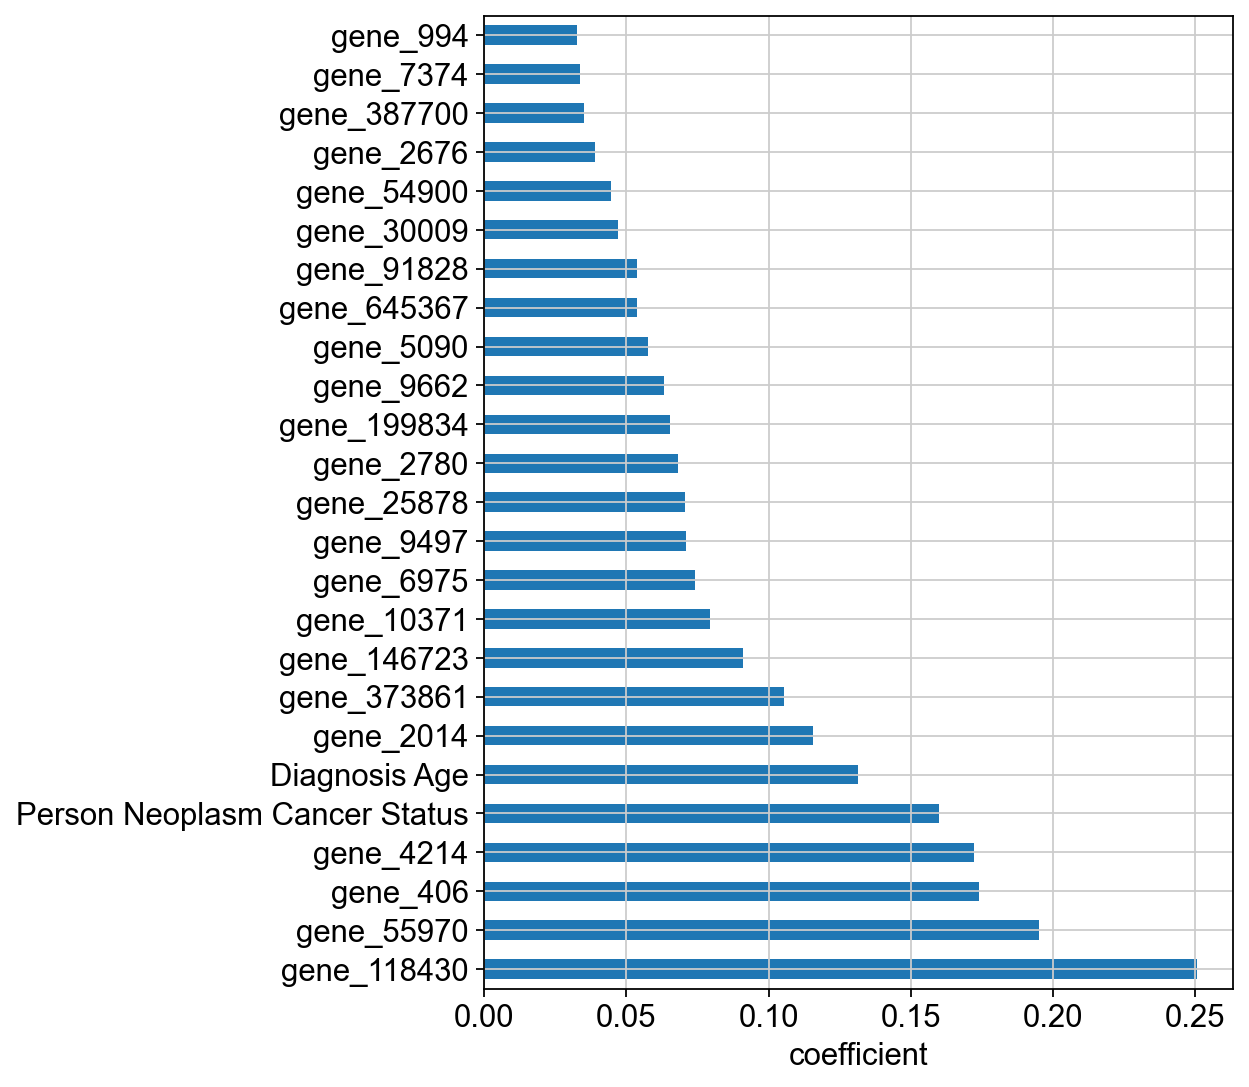

In [118]:
non_zero_coefs = coefs.query("index != 0")
coef_order = non_zero_coefs.abs().index

_, ax = plt.subplots(figsize=(6, 8))
non_zero_coefs.loc[coef_order].iloc[:,-1].nlargest(25).plot.barh(ax=ax, legend=False)
ax.set_xlabel("coefficient")
ax.grid(True)